# Preprocessor
   1. Convert TIFF video to individual TIFF images
        > Clearing the folder and index+1 to have the range 1-300 added
   2. Cellular Segmentation
        > Done by utilizing the CellPose library
   3. Identify the Largest circle detected
        > Output: radius and centroid 
   4. Establish a bounding rectangular area around the circle
        > OpenCV cv2.boundingRect( ) used
   5. Perform cropping based on the bounding rectangular
   6. Save processed data

#### 1. Converting TIFF

In [1]:
import os
import numpy as np
import tifffile
from PIL import Image

# Read the image
imageAll = tifffile.imread('CaSki17.tif')
lengthOfStack = imageAll.shape[0]  # Get the length of the stack
dirToStore = "C:/Users/mkana/Desktop/GPMV/GPMV_new/SingleTiffs/"

for file in os.listdir(dirToStore):
    os.remove(os.path.join(dirToStore, file))

for index in range(lengthOfStack):  # Loop through each frame
    image = np.array(imageAll[index, :, :], dtype=np.uint16)
    image = Image.fromarray(image) # Convert to PIL Image
    image.save(f"{dirToStore}{index+1}.tif")

<tifffile.TiffTag 5033 @530880> coercing invalid ASCII to bytes


#### CellPose

Radius of the biggest detected membrane: 55.901798248291016


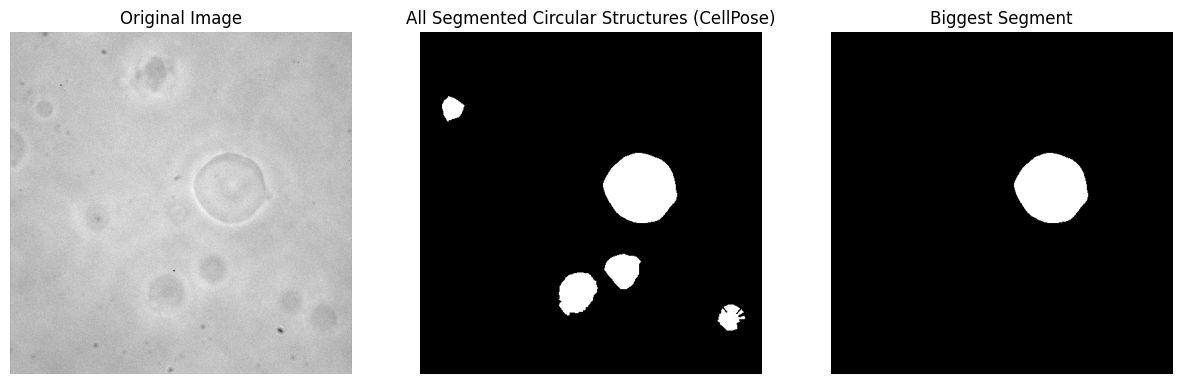

In [82]:
import cv2
from cellpose import models
import numpy as np
import matplotlib.pyplot as plt

image_path = 'C:/Users/mkana/Desktop/GPMV/GPMV_new/SingleTiffs/1.tif'
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

# Contrast stretching
def contrast_stretching(image):
    min_val = np.min(image)
    max_val = np.max(image)
    stretched_image = ((image - min_val) / (max_val - min_val)) * 255
    return stretched_image.astype(np.uint8)

# Initialize CellPose model
model = models.Cellpose(gpu=True, model_type='cyto')

# Segment membranes
masks, flows, styles, diams = model.eval(image, diameter=None, channels=[0, 0])

# Convert masks to uint16 format
masks_uint16 = masks.astype(np.uint16) * 65535

max_radius = 0
max_contour = None

contours, _ = cv2.findContours(masks.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
    (x, y), radius = cv2.minEnclosingCircle(contour)
    if radius > max_radius:
        max_radius = radius
        max_contour = contour

print("Radius of the biggest detected membrane:", max_radius)

# Extract the segmented area of the biggest contour
biggest_segment_mask = np.zeros_like(image)
cv2.drawContours(biggest_segment_mask, [max_contour], -1, (255, 255, 255), thickness=cv2.FILLED)

# Display the segmented membranes
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(masks_uint16, cmap='gray')
plt.title('All Segmented Circular Structures (CellPose)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(biggest_segment_mask, cmap='gray')
plt.title('Biggest Segment')
plt.axis('off')

plt.show()


#### Adding bounding rectangle

Radius of the biggest detected membrane: 55.901798248291016
Center coordinates of the biggest membrane: 330 233
Bounding rectangle coordinates (with 5 pixels added to each side): 269 176 390 291


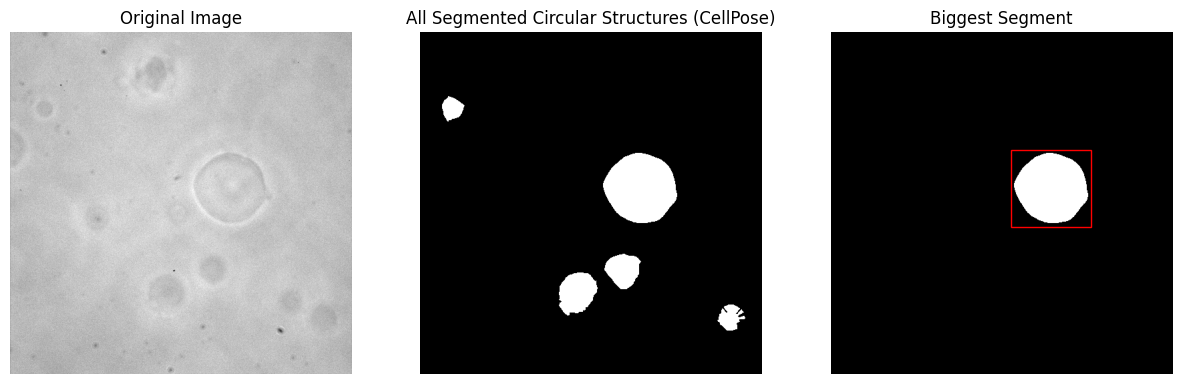

In [92]:
import cv2
from cellpose import models
import numpy as np
import matplotlib.pyplot as plt

image_path = 'C:/Users/mkana/Desktop/GPMV/GPMV_new/SingleTiffs/1.tif'
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

# Contrast stretching
def contrast_stretching(image):
    min_val = np.min(image)
    max_val = np.max(image)
    stretched_image = ((image - min_val) / (max_val - min_val)) * 255
    return stretched_image.astype(np.uint8)

# Initialize CellPose model
model = models.Cellpose(gpu=True, model_type='cyto')

# Segment membranes
masks, flows, styles, diams = model.eval(image, diameter=None, channels=[0, 0])

# Convert masks to uint16 format
masks_uint16 = masks.astype(np.uint16) * 65535

max_radius = 0
max_contour = None

contours, _ = cv2.findContours(masks.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
    (x, y), radius = cv2.minEnclosingCircle(contour)
    if radius > max_radius:
        max_radius = radius
        max_contour = contour

print("Radius of the biggest detected membrane:", max_radius)

# Calculate the centroid of the biggest contour
M = cv2.moments(max_contour)
center_x = int(M["m10"] / M["m00"])
center_y = int(M["m01"] / M["m00"])

print("Center coordinates of the biggest membrane:", center_x, center_y)

# Extract the segmented area of the biggest contour
biggest_segment_mask = np.zeros_like(image)
cv2.drawContours(biggest_segment_mask, [max_contour], -1, (255, 255, 255), thickness=cv2.FILLED)

# Find bounding rectangle around the biggest segment
x, y, w, h = cv2.boundingRect(max_contour)
# Add 10 pixels to each side of the bounding rectangle
x -= 5
y -= 5
w += 10
h += 10
print("Bounding rectangle coordinates (with 5 pixels added to each side):", x, y, x + w, y + h)

# Display the segmented membranes
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(masks_uint16, cmap='gray')
plt.title('All Segmented Circular Structures (CellPose)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(biggest_segment_mask, cmap='gray')
plt.title('Biggest Segment')
plt.axis('off')

# Draw bounding rectangle on the image with 10 pixels added to each side
plt.gca().add_patch(plt.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none'))

plt.show()
